In [66]:
import warnings
warnings.filterwarnings("ignore")  # silence warnings

import pandas as pd
from datetime import datetime,date
from causalnex.structure import StructureModel
from sklearn.preprocessing import LabelEncoder

from causalnex.structure.notears import from_pandas
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE


In [26]:
import sys
sys.path.append("../scripts/")
from data_cleaner import DataCleaner
cleaner = DataCleaner()

In [22]:
df  = pd.read_csv('../data/merged_df.csv')
clean_df = pd.read_csv('../data/clean_merged_df.csv')

In [23]:
clean_df.head()

,order_id,driver_lat,driver_lng,origin_lat,origin_lng,distance_diff,trip_start_time,duration_min,holiday,action_count,driver_action,fulfilled,weekend
0,392001,6.602207,3.270465,6.601042,3.276634,0.694264,2021-07-01 09:30:59,3.0,False,1,accepted,False,False
1,392005,6.549147,3.392184,6.565088,3.384441,1.959786,2021-07-01 10:53:36,34.0,False,1,accepted,True,False
2,392009,6.644829,3.289328,6.663648,3.308206,2.947683,2021-07-01 06:39:51,61.0,False,1,accepted,True,False
3,392013,6.435331,3.424317,6.430817,3.434155,1.197389,2021-07-01 08:44:09,35.0,False,1,accepted,True,False
4,392014,6.498221,3.360042,6.499156,3.358517,0.197853,2021-07-01 06:43:07,44.0,False,1,accepted,True,False


In [24]:
df["date"]=df["trip_start_time"].apply(lambda x: pd.to_datetime(x).date())
df["hour"]=df["trip_start_time"].apply(lambda x: pd.to_datetime(x).hour)
df.drop(columns="trip_start_time",inplace=True)

In [27]:
df = cleaner.find_distance(df,distance_col_name="distance_diff",trip_origin_col_names=["driver_lat","driver_lng"],trip_destination_col_names=["origin_lat","origin_lng"])


In [53]:
temp_df=df.copy()

In [50]:
convert_to_num_cols=["driver_lat","driver_lng","duration_min","origin_lat","origin_lng","hour","distance_diff"]
df = cleaner.convert_to_numbers(df,convert_to_num_cols)

convert_to_str_cols=["driver_id","driver_action","holiday"]
df = cleaner.convert_to_string(df,convert_to_str_cols)

convert_to_date_cols=["date"]
df = cleaner.convert_to_datetime(df,convert_to_date_cols)

# df[convert_to_num_cols] = df[convert_to_num_cols].apply(pd.to_numeric)


# for col in convert_to_str_cols:
#     df[col] = df[col].astype(str)

# df["date"] =  pd.to_datetime(df["date"])


In [51]:
df.head()

,id,order_id,driver_id,driver_action,driver_lat,driver_lng,duration_min,holiday,origin_lat,origin_lng,date,hour,distance_diff
0,1,392001,243828,accepted,6.602207,3.270465,3.0,False,6.601042,3.276634,2021-07-01,9,0.694264
1,2,392001,243588,rejected,6.592097,3.287445,3.0,False,6.601042,3.276634,2021-07-01,9,1.551694
2,3,392001,243830,rejected,6.596133,3.281784,3.0,False,6.601042,3.276634,2021-07-01,9,0.786777
3,4,392001,243539,rejected,6.596142,3.280526,3.0,False,6.601042,3.276634,2021-07-01,9,0.692054
4,5,392001,171653,rejected,6.609232,3.288800,3.0,False,6.601042,3.276634,2021-07-01,9,1.621848


In [58]:

def labe_encoder(df:pd.DataFrame,columns:list=None):
    if columns == None:
        # columns = df.select_dtypes(exclude = ['number','datetime'])
        columns = df.select_dtypes(exclude = ['number'])
    le = LabelEncoder()

    for col in columns:
        df[col] = le.fit_transform(df[col])

    return df

In [61]:
# df = cleaner.label_encoder(df)
df = labe_encoder(df)


In [63]:
df.drop(columns="id",inplace=True)
df.drop(columns="order_id",inplace=True)
df.rename(columns={"driver_id":"driver"},inplace=True)

In [69]:
df.head()


,driver,driver_action,driver_lat,driver_lng,duration_min,holiday,origin_lat,origin_lng,date,hour,distance_diff
0,732,0,6.602207,3.270465,3.0,0,6.601042,3.276634,0,9,0.694264
1,587,1,6.592097,3.287445,3.0,0,6.601042,3.276634,0,9,1.551694
2,734,1,6.596133,3.281784,3.0,0,6.601042,3.276634,0,9,0.786777
3,556,1,6.596142,3.280526,3.0,0,6.601042,3.276634,0,9,0.692054
4,78,1,6.609232,3.288800,3.0,0,6.601042,3.276634,0,9,1.621848


In [70]:

sm = from_pandas(df)

KeyboardInterrupt: 

In [ ]:
df['date'].describe()

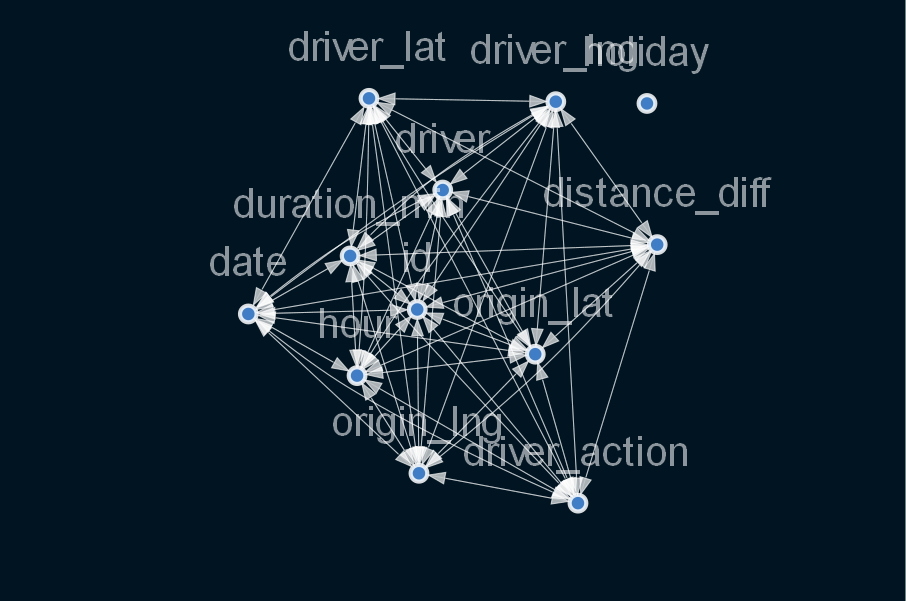

In [67]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
    prog='fdp',
)
Image(viz.draw(format='png'))

In [2]:
sm = StructureModel()

In [3]:
sm.add_edges_from([
    ('health', 'absences'),
    ('health', 'G1')
])

In [4]:
sm.edges

OutEdgeView([('health', 'absences'), ('health', 'G1')])

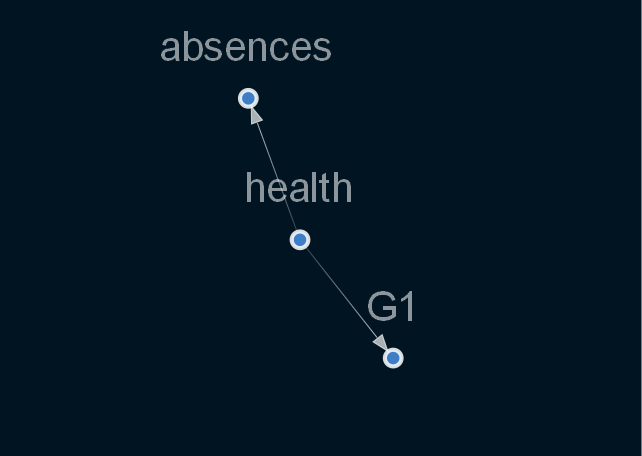

In [5]:


viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))